# RL : Mini Project 2

In this notebook, using BBRL, you will study the effect of partial observability 
on the CartPoleContinuous-v1 environment, using either the DDPG or the TD3 algorithm.

To emulate partial observability, you will design dedicated wrappers. Then you will study
whether extending the input of the agent policy and critic with a memory of previous states
and its output with action chunks can help solve the partial observability issue. This will
also be achieved by designing other temporal extension wrappers.

# Installation

In [102]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
# Prepare the environment
try:
    from easypip import easyimport
except ModuleNotFoundError:
    from subprocess import run

    assert (
        run(["pip", "install", "easypip"]).returncode == 0
    ), "Could not install easypip"
    from easypip import easyimport

easyimport("swig")
easyimport("bbrl_utils").setup(maze_mdp=False)

import os
import copy
import numpy as np
import gymnasium as gym
import math
import bbrl_gymnasium  # noqa: F401
import torch
import torch.nn as nn
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl_utils.algorithms import EpochBasedAlgo
from bbrl_utils.nn import build_mlp, setup_optimizer, soft_update_params
from bbrl_utils.notebook import setup_tensorboard
from bbrl.visu.plot_policies import plot_policy
from omegaconf import OmegaConf

  Using cached easypip-1.3.5-py3-none-any.whl.metadata (475 bytes)
Using cached easypip-1.3.5-py3-none-any.whl (3.8 kB)


[easypip] Installing swig
[easypip] Installing bbrl_utils
/home/hocine/ENTER/envs/miniprojet2/lib/python3.9/site-packages/bbrl_utils/notebook.py:46: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # noqa: F401


In [30]:
from td3_ddpg import DDPG, run_ddpg, TD3, run_td3
import utils
import matplotlib.pyplot as plt

In [156]:
setup_tensorboard("./outputs/tblogs")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 164425), started 0:05:30 ago. (Use '!kill 164425' to kill it.)

# Temporal modification wrappers

The CartPoleContinuous-v1 environment is a custom extension of 
[the CartPole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/) 
with continuous actions, between -1 and 1. It is defined in the bbrl_gymnasium library.

As in CartPole, the state of the system contains 4 variables:
- the position $x$,
- the velocity $\dot{x}$,
- the angle of the pole $\theta$,
- the angular velocity $\dot{\theta}$.

To emulate partial observability in CartPoleContinuous-v1, you will hide the $\dot{x}$ and $\dot{\theta}$ features, 
by filtering them out of the state of the environment. This is implemented with the ```FeatureFilterWrapper```.

To compensate for partial observability, you will extend the architecture of the agent 
with a memory of previous states and its output with action chunks.
This is implemented with to wrappers, the ```ObsTimeExtensionWrapper``` and the ```ActionTimeExtensionWrapper```.

## The FeatureFilterWrapper

The FeatureFilterWrapper removes a feature from the output observation when calling the ```reset()``` and ```step(action)``` functions.
The index of the removed feature is given when building the object.

To hide the $\dot{x}$ and $\dot{\theta}$ features from the CartPoleContinuous-v1 environment, 
the idea is to call the wrapper twice, using something like
```env = FeatureFilterWrapper(FeatureFilterWrapper(inner_env, 3), 1)``` where ```inner_env``` is the CartPoleContinuous-v1 environment.

In [122]:
# class FeatureFilterWrapper(gym.Wrapper):
#     def __init__(self, env, feature_idx):
#         # Initialisation du wrapper avec l'environnement et l'indice de la caractéristique à masquer.
#         super(FeatureFilterWrapper, self).__init__(env)
#         self.feature_idx = feature_idx
        
#         # Adapter l'espace d'observation en retirant une dimension.
#         low = np.delete(self.observation_space.low, feature_idx)
#         high = np.delete(self.observation_space.high, feature_idx)
#         self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)

#     def reset(self):
#         # Réinitialise l'environnement et supprime la caractéristique sélectionnée de l'observation.
#         obs = self.env.reset()
#         filtered_obs = np.delete(obs, self.feature_idx)
#         return filtered_obs

#     def step(self, action):
#         # Exécute une action et masque la caractéristique dans l'observation retournée.
#         obs, reward, done, info = self.env.step(action)
#         filtered_obs = np.delete(obs, self.feature_idx)
#         return filtered_obs, reward, done, info

In [141]:
# class FeatureFilterWrapper(gym.ObservationWrapper):
#     def __init__(self, env, index):
#         super().__init__(env)
#         self.index = index
#         self.filter_observation()

#     def filter_observation(self):
#         old_space = self.observation_space
#         low = np.delete(old_space.low, self.index)
#         high = np.delete(old_space.high, self.index)
#         self.observation_space = gym.spaces.Box(low=low, high=high, dtype=old_space.dtype)

#     def observation(self,obs):
#         return np.delete(obs, self.index)

In [196]:
class FeatureFilterWrapper(gym.Wrapper):
    def __init__(self, env, feature_idx):
        # Initialisation du wrapper avec l'environnement et l'indice de la caractéristique à masquer.
        super(FeatureFilterWrapper, self).__init__(env)
        self.feature_idx = feature_idx
        
        # Adapter l'espace d'observation en retirant une dimension.
        low = np.delete(self.observation_space.low, feature_idx)
        high = np.delete(self.observation_space.high, feature_idx)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)

    def reset(self, seed = None, options = None):
        """
        reset environment to initial state and remove the designated feature
        :param kwargs: keyword arguments for the reset function
        :return: filtered observation, info
        """
        obs, info = self.env.reset()  # get initial state
        filtered_obs = np.delete(obs, self.feature_idx)  # delete designated features
        return filtered_obs, info

    def step(self, action):
        # Exécute une action et masque la caractéristique dans l'observation retournée.
        obs, reward, done, truncated, info = self.env.step(action)
        filtered_obs = np.delete(obs, self.feature_idx)
        return filtered_obs, reward, done, truncated, info

## The ObsTimeExtensionWrapper

When facing a partially observable environment, training with RL a reactive agent which just selects an action based on the current observation
is not guaranteed to reach optimality. An option to mitigate this fundamental limitation is to equip the agent with a memory of the past.

One way to do so is to use a recurrent neural network instead of a feedforward one to implement the agent: the neural network contains
some memory capacity and the RL process may tune this internal memory so as to remember exactly what is necessary from the
past observation. This has been done many times using an LSTM, see for instance 
[this early paper](https://proceedings.neurips.cc/paper/2001/file/a38b16173474ba8b1a95bcbc30d3b8a5-Paper.pdf).

Another way to do so is to equip the agent with a list-like memory of the past observations 
and to extend the critic and policy to take as input the current observation and the previous ones.
This removes the difficulty of learning an adequate representation of the past, but this results in 
enlarging the input size of the actor and critic networks. This can only be done if the required memory
horizon to behave optimally is small enough.

In the case of the CartPoleContinuous-v1 environment, one can see immediately that a memory of the previous
observation is enough to compensate for the absence of the derivative features, since $\dot{a} \approx (a_{t} - a_{t-1})$.

So we will extend the RL agent with a memory of size 1.

Though it may not be intuitive at first glance, the simplest way to do so is to embed the environment into a wrapper
which contains the required memory and produces the extended observations. This way, the RL agent will naturally be built
with an extended observation space, and the wrapper will be in charge of concatenating the memorized
observation from the previous step with the current observation received from the inner environment when calling the ```step(action)``` function.
When calling the ```reset()``` function, the memory of observations should be reinitialized with null observations.

In [201]:
class ObsTimeExtensionWrapper(gym.Wrapper):
    def __init__(self, env, memory_size=1):
        # Initialisation du wrapper avec une mémoire des observations.
        super(ObsTimeExtensionWrapper, self).__init__(env)
        self.memory_size = memory_size
        self.prev_obs = np.zeros_like(self.env.observation_space.low)
        
        # Étendre l'espace d'observation en incluant les observations passées.
        low = np.concatenate([self.observation_space.low] * (memory_size + 1))
        high = np.concatenate([self.observation_space.high] * (memory_size + 1))
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)

    def reset(self, seed=None, options=None):
        # Réinitialise l'environnement et la mémoire des observations.
        obs, info = self.env.reset(seed=seed, options=options)
        self.prev_obs = np.zeros_like(obs)  # Réinitialisation de la mémoire.
        extended_obs = np.concatenate([self.prev_obs, obs])
        return extended_obs, info

    def step(self, action):
        # Exécute une action et combine l'observation actuelle avec la précédente.
        result = self.env.step(action)

        # Gestion du retour avec 4 ou 5 éléments.
        if len(result) == 4:
            obs, reward, done, info = result
            truncated = False
        else:
            obs, reward, done, truncated, info = result

        extended_obs = np.concatenate([self.prev_obs, obs])
        self.prev_obs = obs  # Met à jour la mémoire avec l'observation courante.
        return extended_obs, reward, done, truncated, info

## The ActionTimeExtensionWrapper

It has been observed that, in partially observable environments, preparing to play a sequence of actions and only playing
the first can be better than only preparing for one action. The difference comes from the fact that the critic evaluates
sequences of actions, even if only the first is played in practice.

Similarly to the ObsTimeExtensionWrapper, the corresponding behavior can be implemented with a wrapper.
The size of the action space of the extended environment should be 
M times the size of the action space of the inner environment. This ensures that the policy and the critic
will consider extended actions.
Besides, the ```step(action)``` function should receive an extended actions of size M times the size of an action,
and should only transmit the first action to the inner environment.

In [202]:
class ActionTimeExtensionWrapper(gym.Wrapper):
    def __init__(self, env, action_repeat=1):
        # Initialisation avec l'environnement et la répétition d'actions.
        super(ActionTimeExtensionWrapper, self).__init__(env)
        self.action_repeat = action_repeat
        
        # Étendre l'espace d'action pour gérer les séquences d'actions.
        low = np.concatenate([self.action_space.low] * action_repeat)
        high = np.concatenate([self.action_space.high] * action_repeat)
        self.action_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)

    def step(self, action):
        # Exécuter uniquement la première action de la séquence d'actions.
        first_action = action[:self.action_space.shape[0] // self.action_repeat]
        obs, reward, done, truncated, info = self.env.step(first_action)
        return obs, reward, done, truncated, info

## Launching tensorboard to visualize the results

# Experimental study

To run the experiments below, you can use the [DDPG](https://arxiv.org/pdf/1509.02971.pdf) 
or [TD3](http://proceedings.mlr.press/v80/fujimoto18a/fujimoto18a.pdf) algorithms.

You can just copy paste here the code you have used during the corresponding labs.
We only provide a suggested set of hyper-parameters working well on the CartPoleContinuous-v1 environment for DDPG.

## Definition of the parameters

The logger is defined as `bbrl.utils.logger.TFLogger` so as to use a
tensorboard visualisation.

In [81]:
params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/ddpg-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    # Set to true to have an insight on the learned policy
    # (but slows down the evaluation a lot!)
    "plot_agents": True,
    "algorithm": {
        "seed": 2,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 1,
        "n_steps": 100,
        "nb_evals": 10,
        "discount_factor": 0.8,
        "buffer_size": 1e6,
        "batch_size": 64,
        "tau_target": 0.05,
        "eval_interval": 2_000,
        "max_epochs": 1500,
        # Minimum number of transitions before learning starts
        "learning_starts": 10_000,
        "action_noise": 0.1,
        "architecture": {
            "actor_hidden_size": [400, 300],
            "critic_hidden_size": [400, 300],
        },
    },
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
}

You now have all the elements to study the impact of removing features from the environment
on the training performance, and the impact of temporally extending the agent in mitigating 
partial observability, both with observation and with action extension.

In practice, you should produce the following learning curves:

- a learning curve of your algorithm on the standard CartPoleContinuous-v1 environment with full observability,
- two learning curves, one from removing $\dot{x}$ from CartPoleContinuous-v1 and the other from removing $\dot{\theta}$, 
- one learning curve from removing both $\dot{x}$ and $\dot{\theta}$, 
- the same four learning curves as above, but adding each of the temporal extension wrappers, separately or combined.

The way to combine these learning curves in different figures is open to you but should be carefully considered
depending on the conclusions you want to draw. Beware of drawing conclusions from insufficient statistics.

Discuss what you observe and conclude from this study.

## Configurations des environnements :

Nous allons utiliser les environnements suivants :

* env_full: Environnement complet avec toutes les caractéristiques.
* env_dx: Environnement avec $\dot{x}$ supprimé.
* env_dtheta: Environnement avec $\dot{\theta}$ supprimé.
* env_both: Environnement avec $\dot{x}$ et $\dot{\theta}$ supprimés.

In [13]:
env_full = gym.make("CartPoleContinuous-v1")
env_dx = FeatureFilterWrapper(gym.make("CartPoleContinuous-v1"), 1)
env_dtheta = FeatureFilterWrapper(gym.make("CartPoleContinuous-v1"), 3)
env_both = FeatureFilterWrapper(FeatureFilterWrapper(gym.make("CartPoleContinuous-v1"), 3), 1)

## Configuration des algorithmes DDPG et TD3

Nous allons configurer les deux algorithmes avec les paramètres fournis et entraîner chaque algorithme sur chaque environnement. Cela inclut l'entraînement avec et sans les wrappers temporaux pour les observations et actions.

In [44]:
def train_agent_on_env(env, algo_class, params, algo_name):
    """
    Entraîne l'agent sur un environnement donné et renvoie les statistiques d'apprentissage.
    
    :param env: L'environnement sur lequel entraîner l'agent.
    :param algo_class: La classe de l'algorithme (DDPG ou TD3).
    :param params: Paramètres pour l'algorithme.
    :param algo_name: Nom de l'algorithme ("DDPG" ou "TD3").
    :return: Les courbes d'apprentissage (récompenses, pertes critiques, pertes acteur, étapes, meilleures récompenses).
    """
    algo = algo_class(OmegaConf.create(params))  # Initialisation de l'algorithme

    if algo_name == "DDPG":
        critic_losses, actor_losses, rewards_per_step, steps, best_rewards = run_ddpg(algo)
    elif algo_name == "TD3":
        critic_losses, actor_losses, rewards_per_step, steps, best_rewards = run_td3(algo)

    return critic_losses, actor_losses, rewards_per_step, steps, best_rewards


## Entraînement sur tous les environnements

Nous allons exécuter train_agent_on_env pour les deux algorithmes (DDPG et TD3) sur les environnements crées. 

Ensuite, nous ajoutons les extensions temporelles et ré-exécutons les entraînements.

In [167]:
def feature_filter_wrapper_1(env):
    """Wrapper pour enlever la première feature (par exemple, l'index 1)"""
    return FeatureFilterWrapper(env, 1)

def feature_filter_wrapper_3(env):
    """Wrapper pour enlever la troisième feature (par exemple, l'index 3)"""
    return FeatureFilterWrapper(env, 3)

def feature_filter_wrapper_both(env):
    """Wrapper pour enlever les deux features : première et troisième"""
    return FeatureFilterWrapper(FeatureFilterWrapper(env, 3), 1)

In [170]:
def train_all_envs_and_algorithms(params):
    env_wrappers = {
        "full": [],
        "dx": [feature_filter_wrapper_1],
        "dtheta": [feature_filter_wrapper_3],
        "both": [feature_filter_wrapper_both],
    }
    
    results = {}
    
    # Entraînement avec DDPG
    for env_name, wrappers in env_wrappers.items():
        print(f"train with DDPG in the {env_name} env")
        
        # Initialiser l'algorithme DDPG avec l'environnement
        ddpg_instance = DDPG(OmegaConf.create(params), wrappers)
        critic_losses, actor_losses, rewards_per_step, steps, best_rewards = run_ddpg(ddpg_instance)
        
        # Sauvegarder les résultats pour DDPG
        results[f"DDPG_{env_name}"] = {
            "critic_losses": critic_losses,
            "actor_losses": actor_losses,
            "rewards_per_step": rewards_per_step,
            "steps": steps,
            "best_rewards": best_rewards
        }
    
    # Entraînement avec TD3
    for env_name, wrappers in env_wrappers.items():
        print(f"train with TD3 in the {env_name} env")
        
        # Initialiser l'algorithme TD3 avec l'environnement
        td3_instance = TD3(OmegaConf.create(params), wrappers)
        critic_losses, actor_losses, rewards_per_step, steps, best_rewards = run_td3(td3_instance)
        
        # Sauvegarder les résultats pour TD3
        results[f"TD3_{env_name}"] = {
            "critic_losses": critic_losses,
            "actor_losses": actor_losses,
            "rewards_per_step": rewards_per_step,
            "steps": steps,
            "best_rewards": best_rewards
        }
    
    return results

In [171]:
# Appeler la fonction pour entraîner sur tous les environnements
results = train_all_envs_and_algorithms(params)

train with DDPG in the full env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with DDPG in the dx env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with DDPG in the dtheta env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with DDPG in the both env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with TD3 in the full env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with TD3 in the dx env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with TD3 in the dtheta env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with TD3 in the both env


  0%|          | 0/1500 [00:00<?, ?it/s]

In [185]:
def convert_lists_to_float(nested_dict):
    """
    Convertit toutes les listes de valeurs dans un dictionnaire de dictionnaires en listes de float.

    :param nested_dict: Dictionnaire de dictionnaires avec des listes de valeurs à convertir.
    :return: Dictionnaire de dictionnaires avec toutes les listes de valeurs converties en float.
    """
    return {
        key: {sub_key: [float(value) for value in value_list] for sub_key, value_list in sub_dict.items()}
        for key, sub_dict in nested_dict.items()
    }

res = convert_lists_to_float(results)

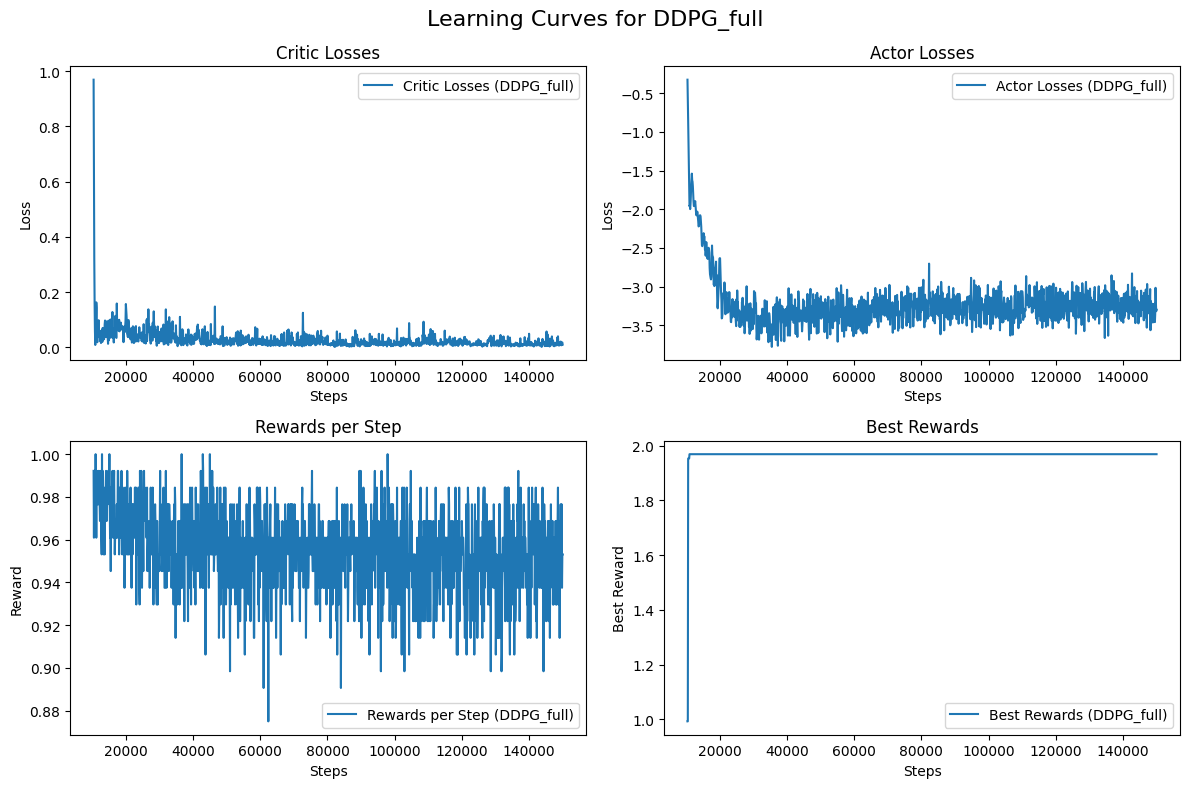

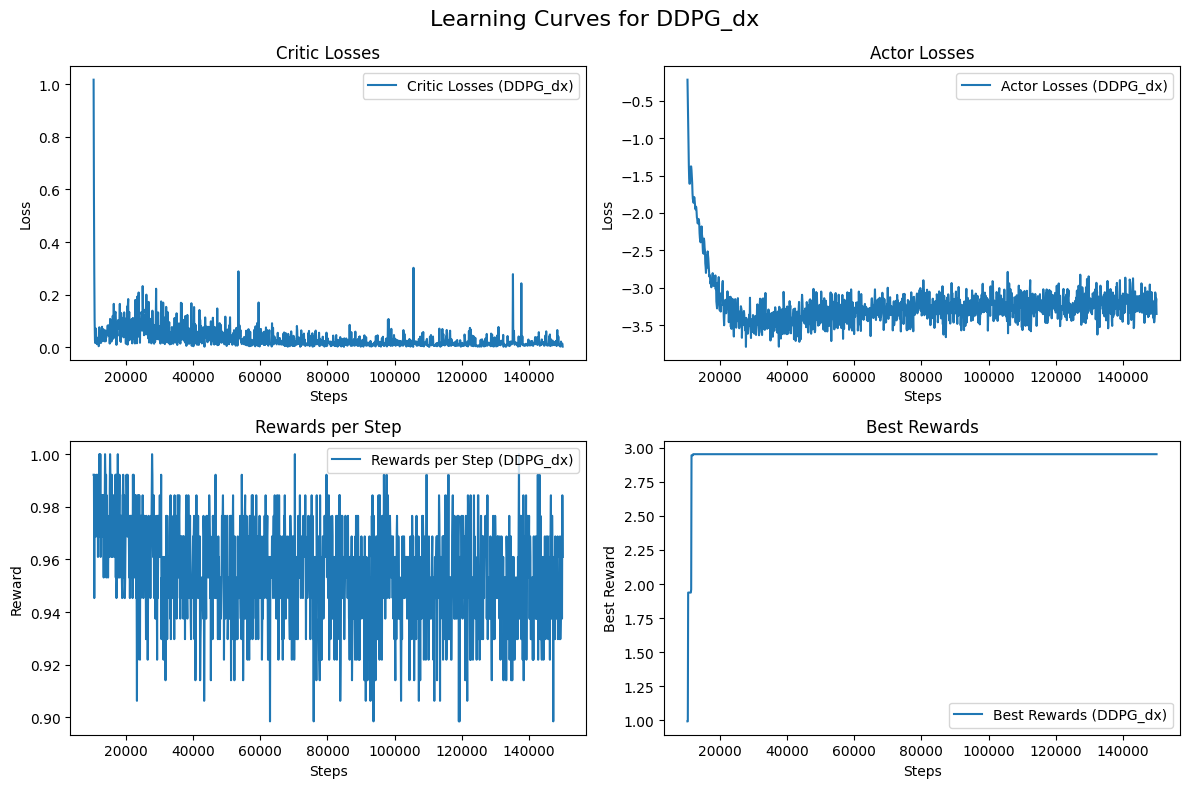

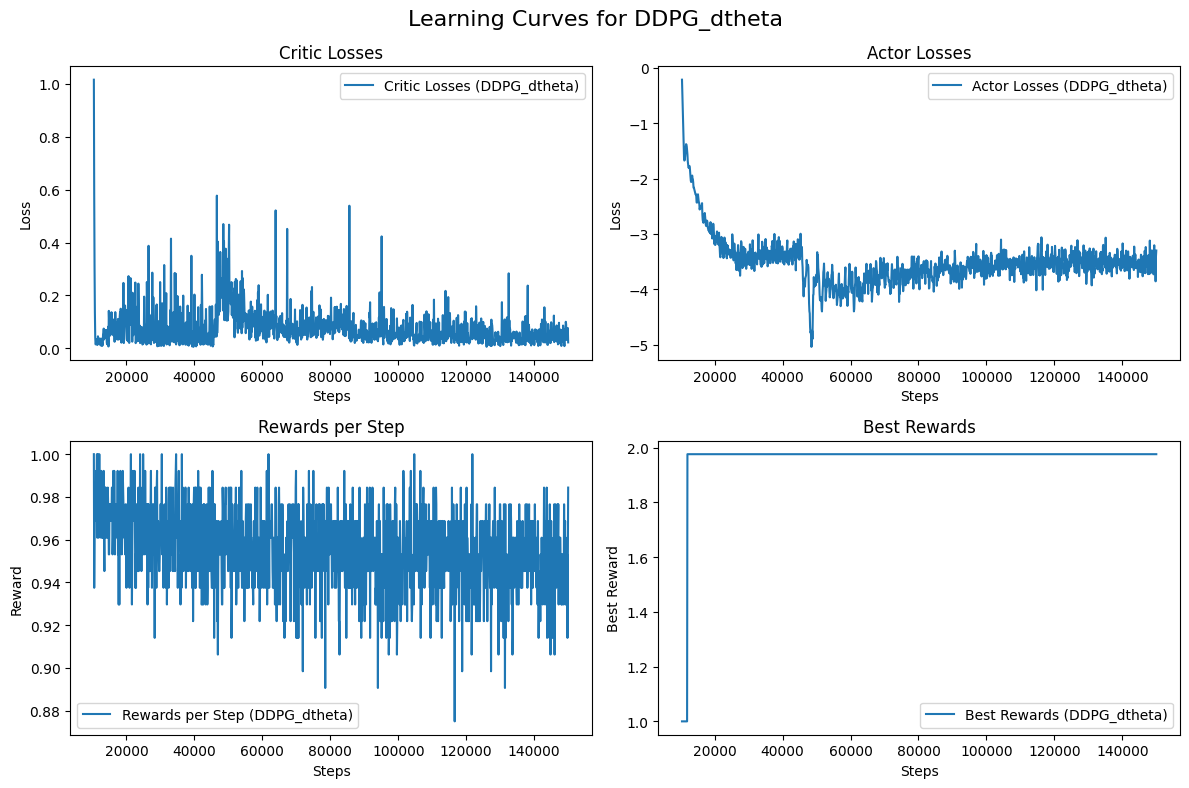

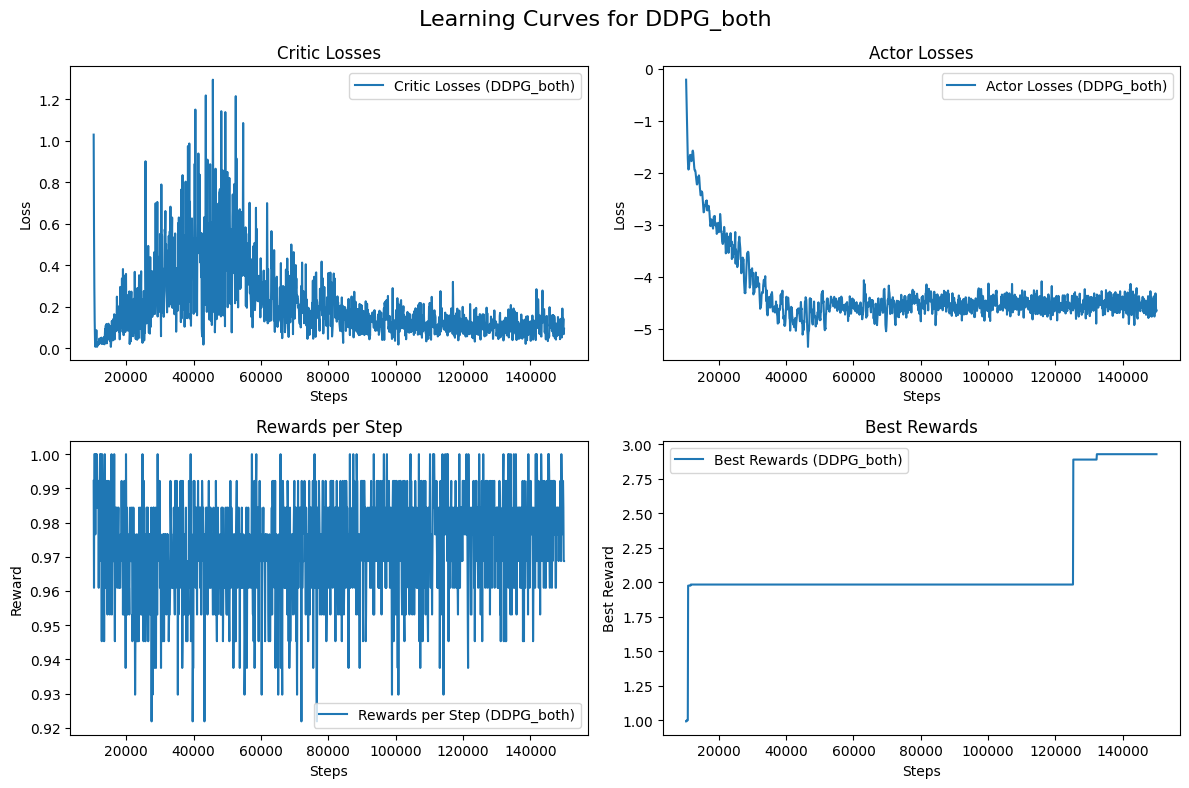

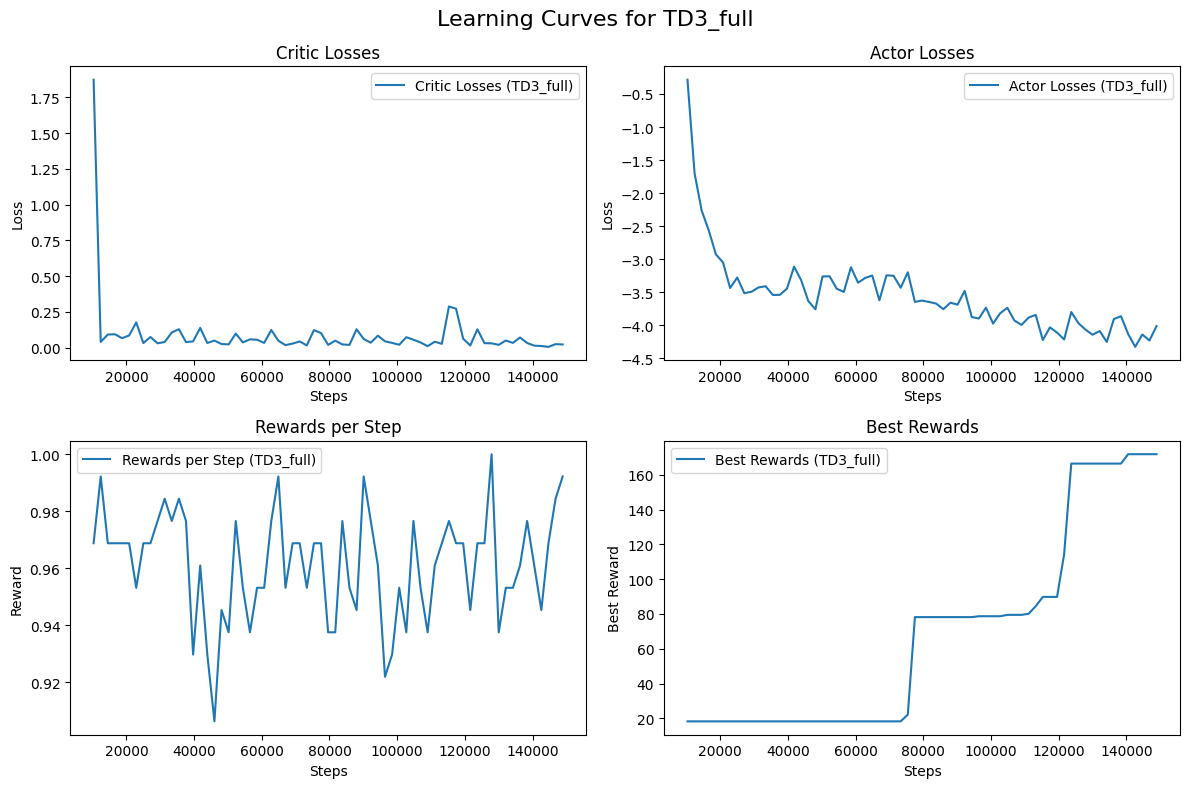

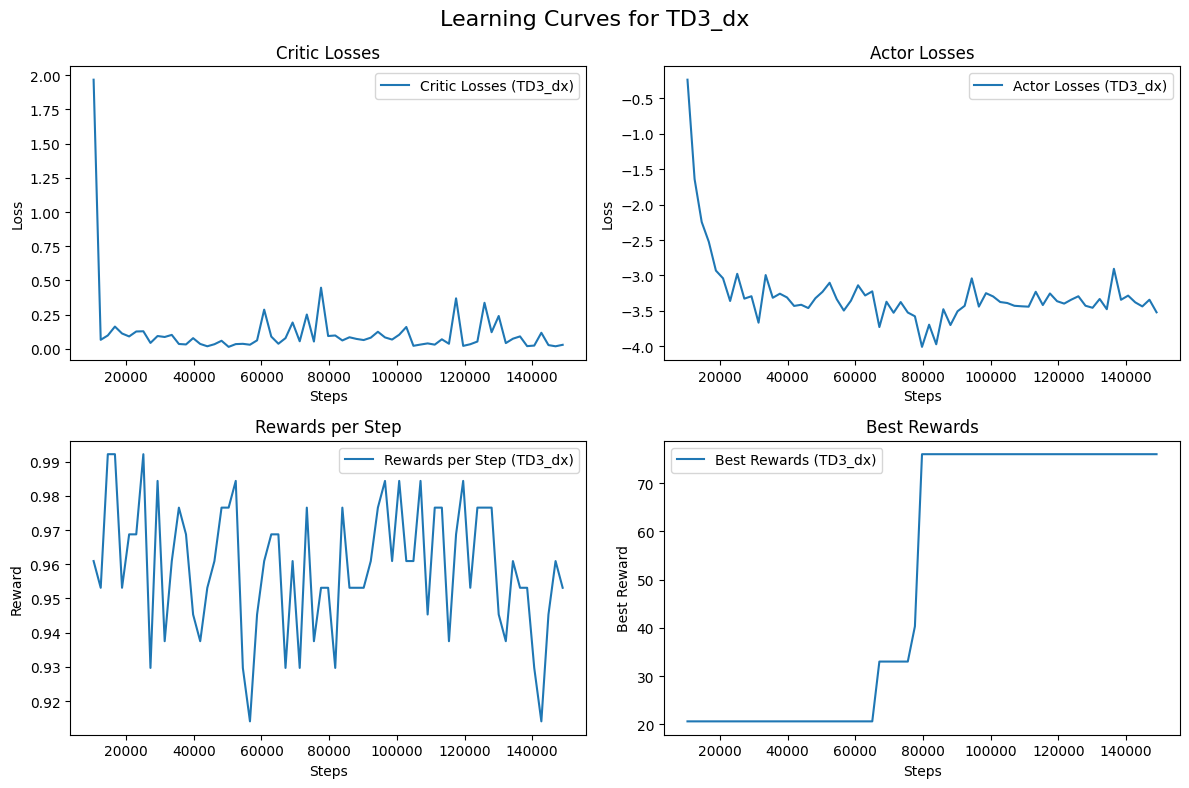

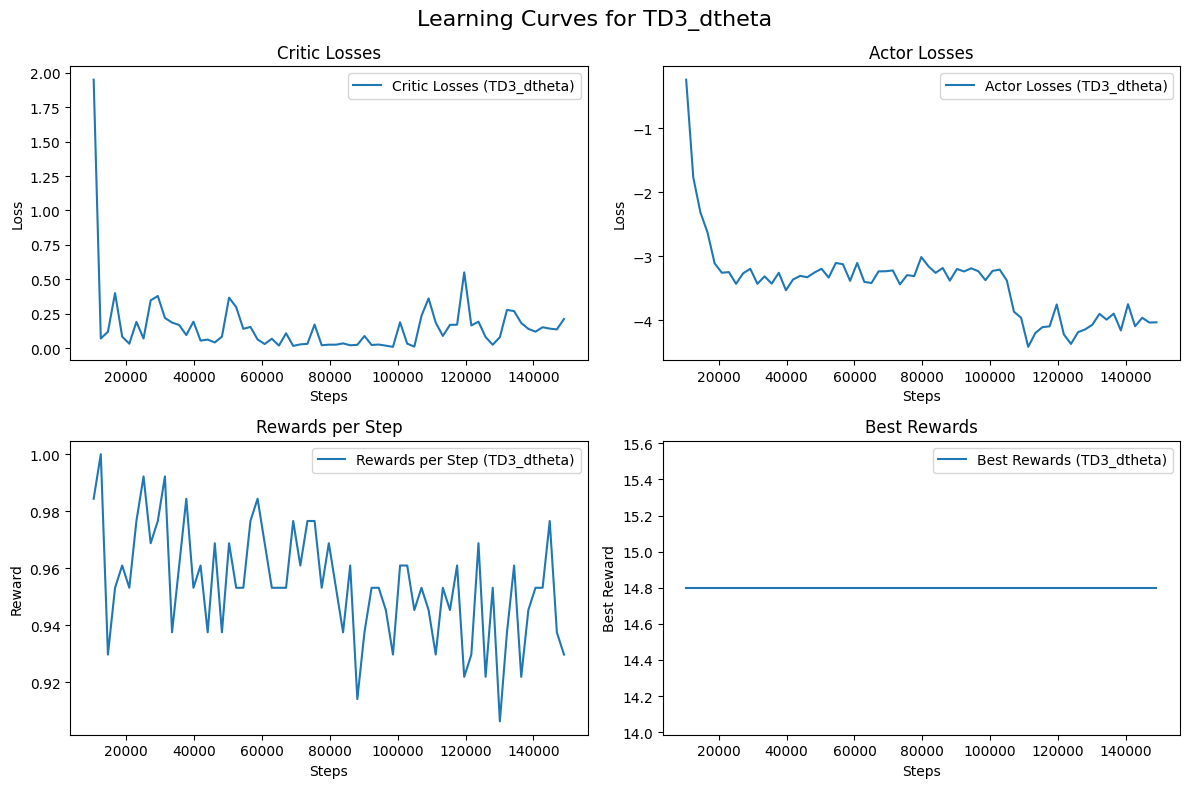

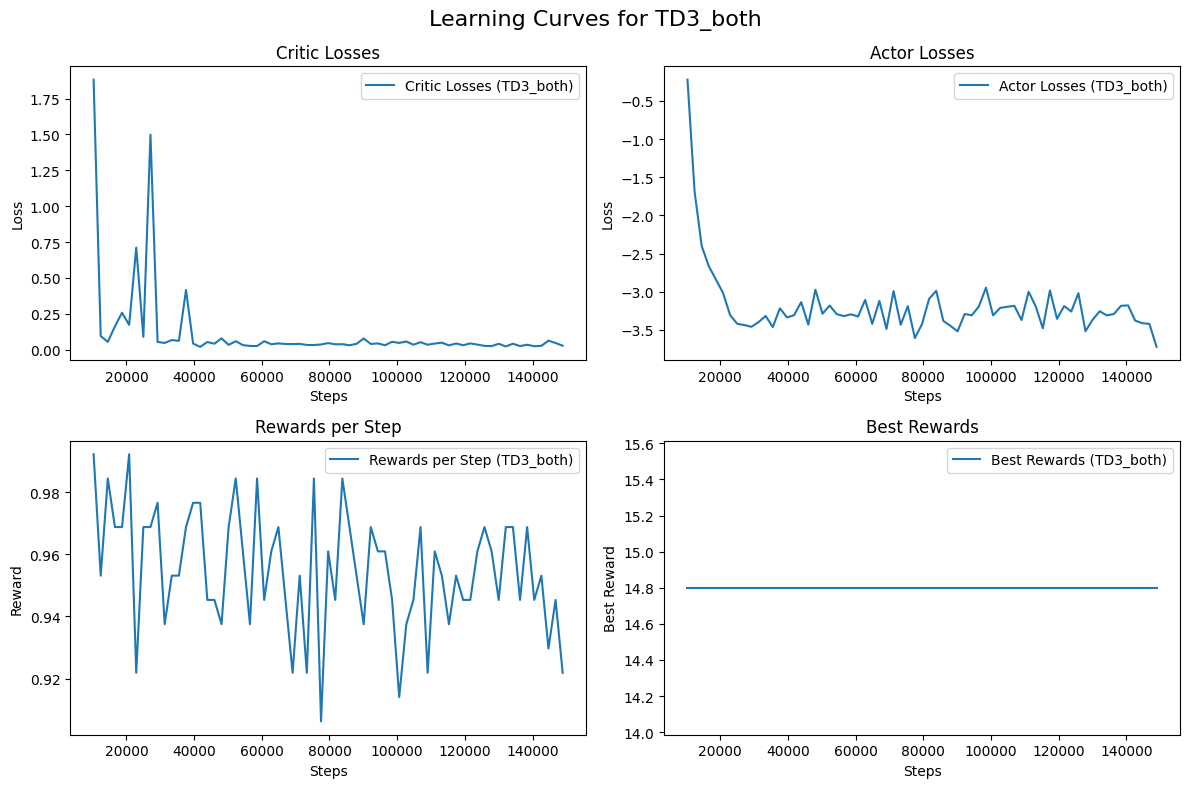

In [187]:
utils.plot_learning_curves(res)

## Entraînement avec les extensions temporelles

Maintenant que nous avons les résultats des environnements sans wrappers temporels, nous allons entraîner chaque algorithme avec les extensions temporelles d'observations et d'actions.



In [189]:
# Fonctions pour ObsTimeExtensionWrapper et ActionTimeExtensionWrapper avec feature filtering

def obs_time_extension_wrapper_dx(env):
    """Appliquer ObsTimeExtensionWrapper et enlever la première feature."""
    return ObsTimeExtensionWrapper(feature_filter_wrapper_1(env))

def obs_time_extension_wrapper_dtheta(env):
    """Appliquer ObsTimeExtensionWrapper et enlever la troisième feature."""
    return ObsTimeExtensionWrapper(feature_filter_wrapper_3(env))

def obs_time_extension_wrapper_both(env):
    """Appliquer ObsTimeExtensionWrapper et enlever les deux features."""
    return ObsTimeExtensionWrapper(feature_filter_wrapper_both(env))

def action_time_extension_wrapper_dx(env):
    """Appliquer ActionTimeExtensionWrapper et enlever la première feature."""
    return ActionTimeExtensionWrapper(feature_filter_wrapper_1(env))

def action_time_extension_wrapper_dtheta(env):
    """Appliquer ActionTimeExtensionWrapper et enlever la troisième feature."""
    return ActionTimeExtensionWrapper(feature_filter_wrapper_3(env))

def action_time_extension_wrapper_both(env):
    """Appliquer ActionTimeExtensionWrapper et enlever les deux features."""
    return ActionTimeExtensionWrapper(feature_filter_wrapper_both(env))

def full_extension_wrapper_dx(env):
    """Appliquer ObsTimeExtensionWrapper, ActionTimeExtensionWrapper et enlever la première feature."""
    return ObsTimeExtensionWrapper(ActionTimeExtensionWrapper(feature_filter_wrapper_1(env)))

def full_extension_wrapper_dtheta(env):
    """Appliquer ObsTimeExtensionWrapper, ActionTimeExtensionWrapper et enlever la troisième feature."""
    return ObsTimeExtensionWrapper(ActionTimeExtensionWrapper(feature_filter_wrapper_3(env)))

def full_extension_wrapper_both(env):
    """Appliquer ObsTimeExtensionWrapper, ActionTimeExtensionWrapper et enlever les deux features."""
    return ObsTimeExtensionWrapper(ActionTimeExtensionWrapper(feature_filter_wrapper_both(env)))


In [203]:
def train_with_extensions(params):
    wrappers_envs_with_extensions = {
        "dx_obs_ext": [obs_time_extension_wrapper_dx],
        "dtheta_obs_ext": [obs_time_extension_wrapper_dtheta],
        "both_obs_ext": [obs_time_extension_wrapper_both],
        "dx_act_ext": [action_time_extension_wrapper_dx],
        "dtheta_act_ext": [action_time_extension_wrapper_dtheta],
        "both_act_ext": [action_time_extension_wrapper_both],
        "dx_full_ext": [full_extension_wrapper_dx],
        "dtheta_full_ext": [full_extension_wrapper_dtheta],
        "both_full_ext": [full_extension_wrapper_both]
    }
    
    results_ext = {}
    
    # Entraînement avec DDPG
    for env_name, wrappers in wrappers_envs_with_extensions.items():
        print(f"train with DDPG in the {env_name} env")
        
        # Initialiser l'algorithme DDPG avec l'environnement
        ddpg_instance = DDPG(OmegaConf.create(params), wrappers)
        critic_losses, actor_losses, rewards_per_step, steps, best_rewards = run_ddpg(ddpg_instance)
        
        # Sauvegarder les résultats pour DDPG
        results_ext[f"DDPG_{env_name}"] = {
            "critic_losses": critic_losses,
            "actor_losses": actor_losses,
            "rewards_per_step": rewards_per_step,
            "steps": steps,
            "best_rewards": best_rewards
        }
    
    # Entraînement avec TD3
    for env_name, wrappers in wrappers_envs_with_extensions.items():
        print(f"train with TD3 in the {env_name} env")
        
        # Initialiser l'algorithme TD3 avec l'environnement
        td3_instance = TD3(OmegaConf.create(params), wrappers)
        critic_losses, actor_losses, rewards_per_step, steps, best_rewards = run_td3(td3_instance)
        
        # Sauvegarder les résultats pour TD3
        results_ext[f"TD3_{env_name}"] = {
            "critic_losses": critic_losses,
            "actor_losses": actor_losses,
            "rewards_per_step": rewards_per_step,
            "steps": steps,
            "best_rewards": best_rewards
        }
    
    return results_ext

In [204]:
results_ext = train_with_extensions(params)

train with DDPG in the dx_obs_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with DDPG in the dtheta_obs_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with DDPG in the both_obs_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with DDPG in the dx_act_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with DDPG in the dtheta_act_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with DDPG in the both_act_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with DDPG in the dx_full_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with DDPG in the dtheta_full_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with DDPG in the both_full_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with TD3 in the dx_obs_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with TD3 in the dtheta_obs_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with TD3 in the both_obs_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with TD3 in the dx_act_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with TD3 in the dtheta_act_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with TD3 in the both_act_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with TD3 in the dx_full_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with TD3 in the dtheta_full_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

train with TD3 in the both_full_ext env


  0%|          | 0/1500 [00:00<?, ?it/s]

In [206]:
def convert_lists_to_float(nested_dict):
    """
    Convertit toutes les listes de valeurs dans un dictionnaire de dictionnaires en listes de float.

    :param nested_dict: Dictionnaire de dictionnaires avec des listes de valeurs à convertir.
    :return: Dictionnaire de dictionnaires avec toutes les listes de valeurs converties en float.
    """
    return {
        key: {sub_key: [float(value) for value in value_list] for sub_key, value_list in sub_dict.items()}
        for key, sub_dict in nested_dict.items()
    }

res_ext = convert_lists_to_float(results_ext)

In [209]:
utils.plot_learning_curves(res_ext)